# **TRAIN AN ACURATE SENTIMENT ANALYSIS MODEL <br>ON AN IMDB COMMENTS DATASET** <br>(to use it on a Kafka's pipeline of tweets)
______

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

### LOAD & PREVIEW DATASET
---


In [ ]:
imdb = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/S5_Kafka_Project/imdb.csv', encoding='ISO-8859-1')

imdb['label'].value_counts()
imdb

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt
...,...,...,...,...,...
99995,99995,train,"Delightfully awful! Made by David Giancola, a ...",unsup,9998_0.txt
99996,99996,train,"Watching Time Chasers, it obvious that it was ...",unsup,9999_0.txt
99997,99997,train,At the beginning we can see members of Troma t...,unsup,999_0.txt
99998,99998,train,"The movie was incredible, ever since I saw it ...",unsup,99_0.txt


In [ ]:
imdb_ok = imdb[['review', 'label']]

In [ ]:
imdb_ok.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


### Delete "unsup" values

In [ ]:
imdb = imdb_ok[imdb_ok.label != "unsup"]

### CREATE TRAIN THE TEST / TRAIN DATASET
---


In [ ]:
X, y = imdb['review'], imdb['label']

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25)

### SENTIMENT ANALYSIS
---


In [ ]:
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Set random seed
seed = 123

# Data manipulation/analysis
import numpy as np
import pandas as pd# Text preprocessing/analysis
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context='talk')

!pip install twython

In [ ]:
imdb['label'].value_counts()

neg    10049
pos     9951
Name: label, dtype: int64

**Convert 'pos' and 'neg' as numerical values**

In [ ]:
def label_sentiment (row):

  if row['label'] == "neg" :
    return 0
  if row['label'] == "pos" :
    return 1

In [ ]:
imdb_def = imdb.apply (lambda row: label_sentiment(row), axis=1)
imdb_def

20151    1
13923    1
5950     0
31056    0
1529     0
        ..
34257    0
1255     0
40565    1
22632    1
25024    0
Length: 20000, dtype: int64

In [ ]:
imdb['target'] = imdb_def
imdb.tail()

,review,label,target
34257,"Ok, I wrote a scathing review b/c the movie is...",neg,0
1255,Wicked Little Things has an excellent synopsis...,neg,0
40565,The British horror film was in terminal declin...,pos,1
22632,This is the most energetic and entertaining te...,pos,1
25024,The worst movie I have seen since Tera Jadoo C...,neg,0


### SPLIT DATA END TRAIN THE MODEL
---

In [ ]:
############### SAMPLING THE DATASET FOR SPEED PURPOSE ######################
imdb = imdb.sample(n=10000) 

In [ ]:
# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(imdb['review'], imdb['target'], test_size=5000, random_state=seed
                                                    #, stratify=imdb_def['target']
                                                    )# Append sentiment back using indices


In [ ]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1) # Check dimensions

print(f"Train: {train.shape[0]} rows and {train.shape[1]} columns")
print(f"{train['target'].value_counts()}\n")

print(f"Test: {test.shape[0]} rows and {test.shape[1]} columns")
print(test['target'].value_counts())

Train: 5000 rows and 2 columns
0    2502
1    2498
Name: target, dtype: int64

Test: 5000 rows and 2 columns
0    2532
1    2468
Name: target, dtype: int64


In [ ]:
############## LAUNCH THE TRAINING ##################

sid = SentimentIntensityAnalyzer()

train[['neg', 'neu', 'pos', 'compound']] = train['review'].apply(sid.polarity_scores).apply(pd.Series)

train.head()

,review,target,neg,neu,pos,compound
39217,"First ever viewing: July 21, 2008<br /><br />V...",1,0.031,0.616,0.354,0.9933
11304,Ho Hum. Just another flick with Steven Seagal ...,0,0.097,0.730,0.173,0.9168
3775,You know you've got a bad film when you hear t...,0,0.129,0.761,0.110,-0.7675
48568,OK. I admit. I'm one of those nerds who have s...,1,0.065,0.770,0.164,0.9979
38047,This movie is inspiring to anyone who is or ha...,1,0.072,0.643,0.285,0.9634


In [ ]:
################ CHECKING THE RESULTS ###################

train.nlargest(10, ['pos'])

,review,target,neg,neu,pos,compound
47124,I LOVE this movie! Beautifully funny and utter...,1,0.000,0.477,0.523,0.9921
22931,Found this movie in a rental store. Never hear...,1,0.000,0.539,0.461,0.9878
40274,this movie is the best movie ever it has a lot...,1,0.000,0.550,0.450,0.9935
42299,"Well, I had seen ""They all laughed"" when it ca...",1,0.035,0.531,0.434,0.9949
48135,IQ is a cute romantic comedy featuring two gre...,1,0.022,0.548,0.430,0.9898
44457,This was Barbra Streisand's first television s...,1,0.000,0.579,0.421,0.9718
38006,"This movie is not about entertainment, or not ...",1,0.037,0.551,0.413,0.9991
48891,i thought this movie was really really great! ...,1,0.035,0.555,0.410,0.9824
40791,"This movie was disaster at Box Office, and the...",1,0.015,0.575,0.409,0.9969
21305,"A beautiful, magical, thought-provoking and he...",1,0.000,0.597,0.403,0.9830


In [ ]:
train.nlargest(10, ['neg'])

,review,target,neg,neu,pos,compound
5519,"This was truly horrible. Bad acting, bad writi...",0,0.580,0.336,0.084,-0.9927
3564,Horrible movie. This movie beat out revenge of...,0,0.466,0.500,0.034,-0.9969
6521,I am the kind of person who can enjoy a good B...,0,0.438,0.503,0.059,-0.9923
8334,Even as a big fan of the low to no budget horr...,0,0.422,0.502,0.075,-0.9790
34319,Acting is horrible. This film makes Fast and F...,0,0.420,0.491,0.090,-0.9972
29095,I've seen about 820 movies released between 19...,0,0.353,0.647,0.000,-0.9468
25220,"People, please don't bother to watch this movi...",0,0.337,0.590,0.073,-0.9489
3747,"This movie is a pure disaster, the story is st...",0,0.334,0.571,0.095,-0.9403
10077,For years I hesitated watching this movie. Now...,0,0.329,0.624,0.047,-0.9951
31909,"Imagine you're a high-school boy, in the back ...",0,0.323,0.632,0.045,-0.9776


**Everything seems ok.**

### PLOT THE RESULTS
---

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

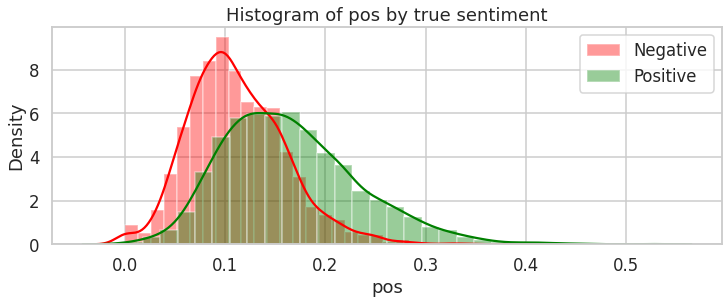

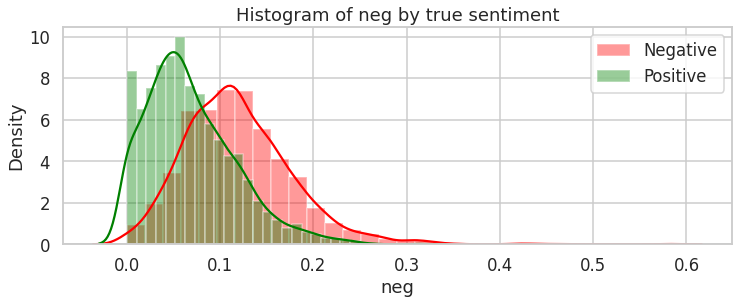

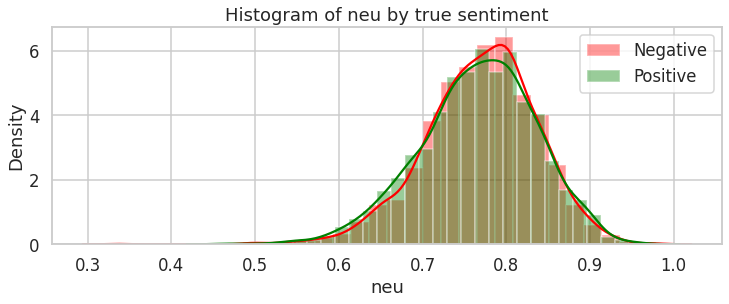

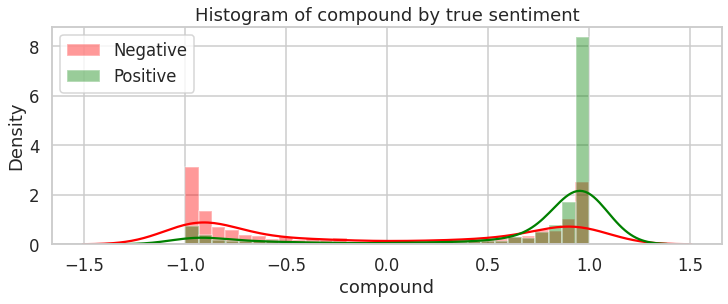

In [ ]:
for var in ['pos', 'neg', 'neu', 'compound']:
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("target==0")[var], bins=30, kde=True, 
                 color='red', label='Negative')
    sns.distplot(train.query("target==1")[var], bins=30, kde=True, 
                 color='green', label='Positive')

    #sns.distplot(train.query("target==0")[var], bins=30, kde=True, 
    #             color='black', label='Neutral')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

### EVALUATE THE ACCURACY OF THE MODEL
---

In [ ]:
train['vader_polarity'] = np.where(train['pos']>train['neg'], 1, 0)
target_names=['negative', 'positive']
print(classification_report(train['target'], 
                            train['vader_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.78      0.53      0.63      2502
    positive       0.64      0.85      0.73      2498

    accuracy                           0.69      5000
   macro avg       0.71      0.69      0.68      5000
weighted avg       0.71      0.69      0.68      5000



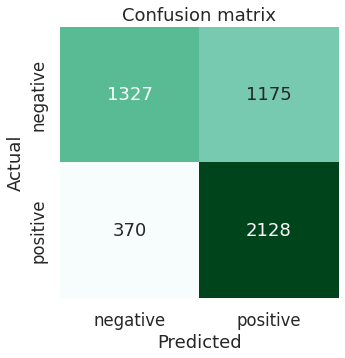

In [ ]:
################ CONFUSION MATRIX ####################

def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,5)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});# Plot confusion matrix

plot_cm(train['target'], train['vader_polarity'])


### REFINE THE MODEL WITH THE COMPOUD SCORE 
---

In [ ]:
train['vader_compound'] = np.where(train['compound']>0, 1, 0)
print(classification_report(train['target'], 
                            train['vader_compound'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.79      0.54      0.64      2502
    positive       0.65      0.85      0.74      2498

    accuracy                           0.70      5000
   macro avg       0.72      0.70      0.69      5000
weighted avg       0.72      0.70      0.69      5000



### PREPROCESSING THE DATA
---

In [ ]:
################ FOR RAPIDITY PURPOSESE WE SAMPLE THE DATASET #################

#imdb = imdb.sample(n=20000) 


!pip install spellchecker
!pip install indexer
!pip install pyspellchecker

  Using cached https://files.pythonhosted.org/packages/c7/2f/49ea001ccc81502fe790c6077ca0cf9c4dc98ce160e1b1225a8c881b53b1/indexer-0.6.2.tar.gz
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
# Measuring run time
from time import time

# Data manipulation/analysis
import numpy as np
import pandas as pd

# Data partitioning
from sklearn.model_selection import train_test_split

# Text preprocessing/analysis
import re, random
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from spellchecker import SpellChecker

In [ ]:
############## A FUNCTION TO UNDERSTAND THE DIFFERENT APPROACHES #################

def inspect(vectoriser, X):
    # Fit and transform
    start = time()
    print(f"There are {vectoriser.fit_transform(X).shape[1]} columns.\n")
    end = time()
    print(f"Took {round((end-start),2)} seconds.\n")
    
    # Inspect tokens
    tokens = list(vectoriser.vocabulary_.keys())
    tokens.sort()
    print(f"Example tokens: {tokens[:50]}\n")
    
    # Inspect ignored tokens
    ignored = vectoriser.stop_words_
    if len(ignored)==0:
        print("No token is ignored.")
    elif len(ignored)>50:
        print(f"Example ignored tokens: {random.sample(ignored, 50)}")
    else:
        print(f"Example ignored tokens: {ignored}")

In [ ]:
################### VECTORISE / TF-IDF VECTORIZATION ############################

vectoriser = TfidfVectorizer()
inspect(vectoriser, X_train)


There are 38851 columns.

Took 0.97 seconds.

Example tokens: ['00', '000', '001', '0069', '007', '00am', '00o', '00pm', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '08th', '0f', '10', '100', '1000', '10000', '1000000', '1000lb', '100th', '100x', '101', '103', '104', '105', '108', '10lines', '10th', '11', '110', '1100', '110mph', '111', '112', '1138', '116', '117', '118', '11th', '11ths', '12', '120', '125', '12m']

No token is ignored.


In [ ]:
vectoriser = TfidfVectorizer(token_pattern=r'[a-z]+', stop_words='english', min_df=30, max_df=.9)
inspect(vectoriser, X_train)

There are 2538 columns.

Took 0.75 seconds.

Example tokens: ['ability', 'able', 'absolute', 'absolutely', 'absurd', 'academy', 'accent', 'accents', 'accept', 'accepted', 'accident', 'accidentally', 'according', 'account', 'accurate', 'accused', 'achieve', 'act', 'acted', 'acting', 'action', 'actions', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'adam', 'adaptation', 'add', 'added', 'adding', 'addition', 'adds', 'admit', 'admittedly', 'adult', 'adults', 'adventure', 'adventures', 'advice', 'affair', 'afraid', 'africa', 'african', 'afternoon', 'age', 'aged']

Example ignored tokens: ['flavin', 'justin', 'hellbreeder', 'reasonable', 'orko', 'hohl', 'energetic', 'dencik', 'peril', 'categorizing', 'sasaki', 'coltrane', 'estrangement', 'untrustworthy', 'ibsen', 'ribs', 'documented', 'shatner', 'bhag', 'deadringer', 'gein', 'disparagement', 'cook', 'cements', 'okkadu', 'unreasonable', 'lilliputian', 'aggressors', 'asylum', 'pudding', 'goat', 'downer', 'bandara', 

In [ ]:
#print(len(vecto_bis.stop_words))
print(len(vectoriser.stop_words_))

35253


In [ ]:
############## (PART OF SPEACH TAGGING) LEMMATIZATION, BASED ON TOKENS ################

def preprocess_text(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    ################## TAKE TOO LONG #####################
    # 2. POS tagging
    #pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    #pos_tags = pos_tag(tokens)
    
    # 3. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') for t in tokens]
    #tokens = [lemmatiser.lemmatize(t.lower(), pos=pos_map.get(p[0], 'v')) for t, p in pos_tags]
    return tokens

In [ ]:
#nltk.download('averaged_perceptron_tagger')


In [ ]:
############## LET'S DO IT ##############################################################

vectoriser = TfidfVectorizer(analyzer=preprocess_text, min_df=30, max_df=.7)
inspect(vectoriser, X_train)

There are 2480 columns.

Took 5.35 seconds.

Example tokens: ['abandon', 'ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'absurd', 'abuse', 'academy', 'accent', 'accept', 'accident', 'accidentally', 'accompany', 'accomplish', 'accord', 'account', 'accurate', 'accuse', 'achieve', 'across', 'act', 'action', 'actor', 'actors', 'actress', 'actresses', 'actual', 'actually', 'adam', 'adapt', 'adaptation', 'add', 'addition', 'address', 'admire', 'admit', 'admittedly', 'adore', 'adult', 'adults', 'advance', 'advantage', 'adventure', 'advertise', 'advice', 'affair', 'affect', 'afraid']

Example ignored tokens: ['mediterranean', 'biochemical', 'mileage', 'nevada', 'unintelligent', 'loneliness', 'cula', 'lucchetti', 'taunt', 'marshall', 'organs', 'tropical', 'raccoons', 'larter', 'afghanistan', 'efface', 'sue', 'hoity', 'backdrop', 'aboard', 'inarticulate', 'cruise', 'contemplation', 'sceptical', 'restaurants', 'neutral', 'weber', 'misogynistic', 'corporate', 'feminine', 'amongst',

### MODELING 
---

In [ ]:
# Define functions
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('log', LogisticRegression(random_state=seed, 
                                             max_iter=1000)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('mnb', MultinomialNB()))
    return models
    
    
def assess(X, y, models, cv=5, scoring=['roc_auc', 
                                    'accuracy', 
                                    'f1']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                            scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [ ]:
models = create_baseline_models()
models

[('log',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                l1_ratio=0.15, learning_rate='optimal', loss='hinge',
                max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
                power_t=0.5, random_state=123, shuffle=True, tol=0.001,
                validation_fraction=0.1, verbose=0, warm_start=False)),
 ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

**Evaluate the performance**

In [ ]:
# Preprocess the data
vectoriser = TfidfVectorizer(token_pattern=r'[a-z]+', 
                             stop_words='english', 
                             min_df=30, 
                             max_df=.7)
X_train_simpler = vectoriser.fit_transform(X_train)# Assess the model
assess(X_train_simpler, y_train, models)

,log,sgd,mnb
fit_time_mean,0.091239,0.025745,0.005088
fit_time_std,0.024438,0.001921,0.000126
score_time_mean,0.003886,0.004087,0.004184
score_time_std,0.000365,0.000236,0.000105
test_accuracy_mean,0.852600,0.835000,0.844400
test_accuracy_std,0.011014,0.009772,0.013576
test_f1_mean,0.855224,0.836846,0.844808
test_f1_std,0.010942,0.009778,0.013854
test_roc_auc_mean,0.931641,0.914472,0.923673
test_roc_auc_std,0.009512,0.009108,0.006944


**1/ It seems that the Logical Regression is the most accurate classifier for our task**
<br>
**2/ But in te meantime, SGD is quicker to perform, with an almost equivalent precision**
<br>
***-------> We'll then use SGD for modelling*** 

Summary of our approach : 


```
# Define function
def preprocess_text(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') 
              for t in tokens]
    return tokens# Preprocess the data
vectoriser = TfidfVectorizer(analyzer=preprocess_text, 
                             min_df=30, 
                             max_df=.7)
X_train_simple = vectoriser.fit_transform(X_train)# Assess models
assess(X_train_simple, y_train, models)
```




### PIPELINE PREPARATION 
---


In [ ]:

pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+')),
                 ('model', SGDClassifier(random_state=seed))])

# Prepare a random search
param_distributions = {'vectoriser__min_df': np.arange(10, 1000, 10),
                       'vectoriser__max_df': np.linspace(.2, 1, 40),
                       'model__loss': ['log', 'hinge']}

r_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=seed)

r_search.fit(X_train, y_train)

# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
r_search_results.head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectoriser__min_df,param_vectoriser__max_df,param_model__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,1.228846,0.026378,0.245722,0.016942,100,0.528205,log,"{'vectoriser__min_df': 100, 'vectoriser__max_d...",0.849,0.856,0.832,0.851,0.831,0.8438,0.010303,1
1,1.223762,0.013004,0.260517,0.019750,100,0.938462,hinge,"{'vectoriser__min_df': 100, 'vectoriser__max_d...",0.843,0.858,0.820,0.843,0.834,0.8396,0.012468,2
9,1.216839,0.031955,0.237223,0.009275,140,0.671795,hinge,"{'vectoriser__min_df': 140, 'vectoriser__max_d...",0.838,0.841,0.832,0.843,0.823,0.8354,0.007228,3
23,1.226018,0.028105,0.239170,0.002945,170,0.917949,log,"{'vectoriser__min_df': 170, 'vectoriser__max_d...",0.826,0.845,0.814,0.843,0.834,0.8324,0.011430,4
0,1.252821,0.041568,0.256380,0.015767,190,0.938462,log,"{'vectoriser__min_df': 190, 'vectoriser__max_d...",0.825,0.837,0.800,0.836,0.827,0.8250,0.013372,5
13,1.216109,0.020003,0.235940,0.005827,170,0.589744,hinge,"{'vectoriser__min_df': 170, 'vectoriser__max_d...",0.821,0.831,0.816,0.836,0.818,0.8244,0.007761,6
4,1.223353,0.027346,0.246086,0.007000,20,0.220513,hinge,"{'vectoriser__min_df': 20, 'vectoriser__max_df...",0.819,0.827,0.820,0.825,0.819,0.8220,0.003347,7
15,1.217115,0.013779,0.238443,0.006024,210,0.671795,hinge,"{'vectoriser__min_df': 210, 'vectoriser__max_d...",0.813,0.824,0.810,0.833,0.813,0.8186,0.008639,8
28,1.218565,0.014747,0.236174,0.004162,210,0.774359,hinge,"{'vectoriser__min_df': 210, 'vectoriser__max_d...",0.815,0.824,0.815,0.829,0.809,0.8184,0.007144,9
22,1.216558,0.038268,0.234529,0.004536,130,0.220513,log,"{'vectoriser__min_df': 130, 'vectoriser__max_d...",0.819,0.819,0.810,0.821,0.815,0.8168,0.003919,10


***We create another DataFrame with the most revelant values only (min_df, max_df, loss) :***

In [ ]:
columns = [col for col in r_search_results.columns 
           if re.search(r"split|param_", col)]

r_summary = r_search_results[columns].copy()

r_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in r_summary.columns]

columns = [col.split('__')[1] if '__' in col else col 
           for col in r_summary.columns ]

r_summary.columns = columns

r_summary.head(20)

,min_df,max_df,loss,split0,split1,split2,split3,split4
11,100,0.528205,log,0.849,0.856,0.832,0.851,0.831
1,100,0.938462,hinge,0.843,0.858,0.820,0.843,0.834
9,140,0.671795,hinge,0.838,0.841,0.832,0.843,0.823
23,170,0.917949,log,0.826,0.845,0.814,0.843,0.834
0,190,0.938462,log,0.825,0.837,0.800,0.836,0.827
13,170,0.589744,hinge,0.821,0.831,0.816,0.836,0.818
4,20,0.220513,hinge,0.819,0.827,0.820,0.825,0.819
15,210,0.671795,hinge,0.813,0.824,0.810,0.833,0.813
28,210,0.774359,hinge,0.815,0.824,0.815,0.829,0.809
22,130,0.220513,log,0.819,0.819,0.810,0.821,0.815


***And we plot the performance accordingly ***

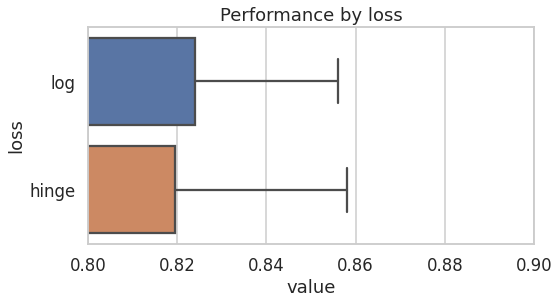

In [ ]:
# Create a long dataframe
r_summary_long = pd.melt(r_summary, 
                         id_vars=['min_df', 
                                  'max_df', 
                                  'loss'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])

# Plot hyperparameter 'loss'
plt.figure(figsize=(8,4))
plt.title('Performance by loss')
sns.boxplot(x='value', y='loss', data=r_summary_long, 
            orient='h')
plt.xlim(.8, .9);

**The hinge parameter is better than log as modell loss**

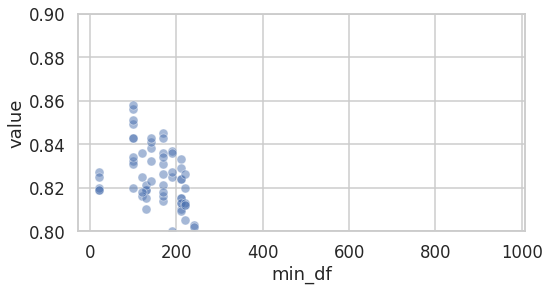

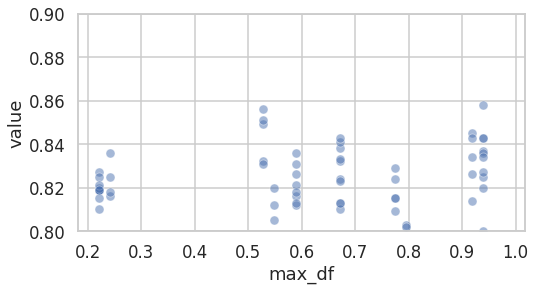

In [ ]:
for param in ['min_df', 'max_df']:
  
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=param, y="value", data=r_summary_long, 
                    x_jitter=True, alpha=0.5)
    
    plt.ylim(.8, .9);

***min_df should be set under 200 for maximum efficiency***
<br>
***max_df seems to have a peak at 0.6 but it remains not very significant***


### FINAL PIPELINE 
---

In [ ]:
pipe = Pipeline([('vectoriser', 
                  TfidfVectorizer(token_pattern=r'[a-z]+', 
                                  min_df=30, 
                                  max_df=.6, 
                                  ngram_range=(1,2))),
                 ('model', 
                  SGDClassifier(random_state=seed, loss='hinge'))])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectoriser',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.6, max_features=None,
                                 min_df=30, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False, token_pat...
                ('model',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                  

In [ ]:
############# THE COEFICIENTS OF OUR PIPELINE 

coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())

coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')


#### CHECK RESULTS
print(coefs.head(20))
print('\n')
print(coefs.tail(20))


                  coef
bad          -4.884743
awful        -4.541630
worst        -3.987124
terrible     -3.710393
boring       -3.194282
the worst    -3.001368
poor         -2.966844
waste        -2.652361
minutes      -2.520903
looks        -2.408077
weak         -2.404140
instead      -2.315516
silly        -2.304970
lame         -2.294575
mess         -2.277235
fails        -2.261377
problem with -2.256685
poorly       -2.204809
the only     -2.148440
script       -2.133500


                coef
certainly   1.806653
touching    1.922010
dirty       1.933649
watch it    1.979450
atmosphere  1.981267
will        2.008019
today       2.024163
the best    2.080612
best        2.163759
amazing     2.173514
surprised   2.236152
highly      2.252468
liked       2.289286
both        2.338606
wonderful   2.514888
incredible  2.674617
brilliant   2.742986
perfect     2.815609
excellent   3.317110
great       3.527559


***Everything seems fine***
<br>
***Let's evaluate the precision of the predictions*** 

In [ ]:
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, 
                            y_train, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.98      0.99      0.98      2490
    positive       0.99      0.98      0.98      2510

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [ ]:
test_pred = pipe.predict(X_test)
print(classification_report(test_pred, 
                            y_test, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      2524
    positive       0.87      0.86      0.86      2476

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



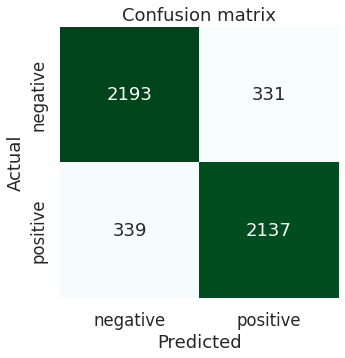

In [ ]:
plot_cm(test_pred, y_test, target_names=target_names)